# **Using Neural Nets to Score Colliding Galaxy Models**

# **1. Imports and general functions**

Here we import the necessary modules for both of our networks, we will be using a single layer and convolution network.

In [1]:
import keras
from keras import backend as K
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
from IPython.display import display
from keras.utils.vis_utils import plot_model
from keras.preprocessing import image
from keras.applications.xception import preprocess_input, decode_predictions

Using TensorFlow backend.


##### **Function to grab and flatten images**

In [2]:
# We need to be able to take an image and turn it into information the
# net can use to learn from and compare to.  So let's turn our images into
# arrays that it will be ablt to interpret.

def grab_image_flatten(img_path_base, index, numImages):
    #Desired image dimension (image will be square ie # by # pixels)
    imageDim = 100
    
    if (index<10):
        img_path = img_path_base+"000"+str(index)+"_model.png"
    elif (index<100 and index >=10):
        img_path = img_path_base+"00"+str(index)+"_model.png"
    elif (index<1000 and index>=100):
        img_path = img_path_base+"0"+str(index)+"_model.png"
    elif (index<10000 and index>=1000):
        img_path = img_path_base+str(index)+"_model.png"
        
    img = image.load_img(img_path, target_size=(imageDim, imageDim), color_mode = "grayscale")
    x = image.img_to_array(img)
    x = x.flatten()
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def grab_image_full(img_path_base, index, numImages):
    #Desired image dimension (image will be square ie # by # pixels)
    imageDim = 100
    
    if (index<10):
        img_path = img_path_base+"000"+str(index)+"_model.png"
    elif (index<100 and index >=10):
        img_path = img_path_base+"00"+str(index)+"_model.png"
    elif (index<1000 and index>=100):
        img_path = img_path_base+"0"+str(index)+"_model.png"
    elif (index<10000 and index>=1000):
        img_path = img_path_base+str(index)+"_model.png"
        
    img = image.load_img(img_path, target_size=(imageDim, imageDim), color_mode = "grayscale")
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

# **2a. Single Layer Network**

This was our starting network.  A simple single layer network to see how well a neural network could learn and compare with our image data.  Our main goal was a convolution network though, so this one just gave us a baseline to work with, and see that the neural network could learn from our data set.

##### **Grab images for the Single Layer Network**

In [3]:
#Num of images to read in
numImages = 600
X = np.concatenate([grab_image_flatten('./miscImgs/',i, numImages) for i in range(numImages)]) 
X /= 255.0
Xoriginal = np.concatenate([grab_image_full('./miscImgs/',i, numImages) for i in range(numImages)]) 
Xoriginal /= 255.0

display(X.shape)
display(Xoriginal.shape)

(600, 10000)

(600, 100, 100, 1)

##### **Load in model scores**

In [4]:
# We need to attach our human scores to the image data

Y = np.loadtxt('miscImgs/scores/humanScores.txt')
Y=Y[0:600]
display(Y[0:10])
display(Y.shape)

array([0.945946, 0.941176, 0.918919, 0.916667, 0.916667, 0.914286,
       0.914286, 0.911765, 0.891892, 0.885714])

(600,)

##### **Shuffle model images**

In [5]:
# Let's shuffle the image data while keeping the human scores properly attached

p = np.random.permutation(len(X))
X_original_shuffled = Xoriginal[p]
Xshuffled = X[p]
Yshuffled = Y[p]

display(X_original_shuffled.shape)
display(Xshuffled.shape)
display(Yshuffled.shape)

(600, 100, 100, 1)

(600, 10000)

(600,)

##### **Split into training and test data (85% for training and validation)**

In [6]:
x_train = Xshuffled[0:(round(numImages*.85)),:]
y_train = Yshuffled[0:(round(numImages*.85))]
x_original_train = X_original_shuffled[0:(round(numImages*.85)),:,:]
x_test = Xshuffled[(round(numImages*.85)): , :]
y_test = Yshuffled[(round(numImages*.85)):]
x_original_test = X_original_shuffled[(round(numImages*.85)): , : , :]

display(x_train.shape)
display(y_train.shape)
display(x_original_train.shape)
display(x_test.shape)
display(y_test.shape)
display(x_original_test.shape)

(510, 10000)

(510,)

(510, 100, 100, 1)

(90, 10000)

(90,)

(90, 100, 100, 1)

##### **Load Pre-Trained Single Layer Network**

In [7]:
singleModel = load_model('SingleModelPaper')

singleModel.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 1)                 10001     
Total params: 10,001
Trainable params: 10,001
Non-trainable params: 0
_________________________________________________________________


# **2b. What the Single Layer Model accomplishes**

The single layer network is accurate enough to say that it works, but there is still too much variation in our results to consider a single layer network as a replacement for human scoring.

In [9]:
preds = singleModel.predict(x_test)
diff = preds.flatten() - (y_test)
print("Mean difference")
print("---------------")
display(np.mean(np.abs(diff)))

Mean difference
---------------


0.09224296327099801

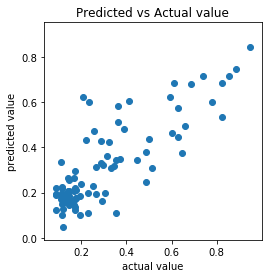

In [10]:
plt.figure()
plt.scatter(y_test, preds)
plt.title("Predicted vs Actual value")
plt.ylabel("predicted value")
plt.xlabel("actual value")
plt.axis('square')
plt.savefig("SinglePredictedVAct.png")
plt.show()

We can see the linear correlation between the predicted scores of our network, and the actual scores given to the models.<br>
There is still a lot of variation, illustrated by how wide the dots spread from the y=x trend.

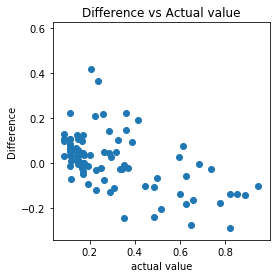

In [11]:
plt.figure()
plt.scatter(y_test, diff)
plt.title("Difference vs Actual value")
plt.ylabel("Difference")
plt.xlabel("actual value")
plt.axis('square')
plt.savefig("SingleDiffVAct.png")
plt.show()

Here we are looking for y=0, instead of our y=x above.<br>
This illustrates that the network rated many of the images as higher than humans did, as well as rating some lower than humans did.<br>
This could mean many things, there are variations in human ratings and the training set might have also been too small.<br>

##### **Find the 5 best and worst predictions**

To make things more clear, let's view some of the actual images used.<br>
The network is able to successfully rate collisions with unique features or very littledistortion.<br>
The largest variations come from the ones with many spirals and twists in the bridges and tails. The more variation, the harder to classify.<br>
We believe this is mostly due to overfitting, with our small data set.

In [12]:
# We can view our best and worst predictions from the model
# the "top" array being our best, and "bottom" array being our worst
# our ratings are based on how close the model rated a particular image
# in regards to the actual human score attached to the image.

absDiff = np.abs(diff)

bottom = np.argpartition(absDiff, -5)[-5:]
top = np.argpartition(absDiff, 5)[:5]

##### **Show the 5 best and worst predictions**

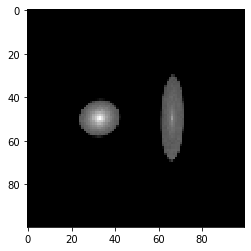

Human Score


0.176471

Prediction


0.17526352

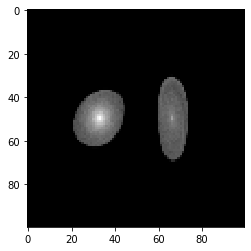

Human Score


0.166667

Prediction


0.16618533

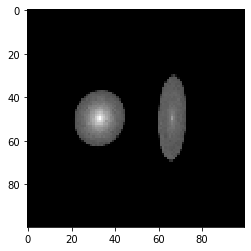

Human Score


0.176471

Prediction


0.17698903

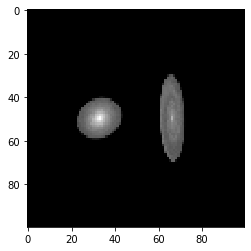

Human Score


0.171429

Prediction


0.17365713

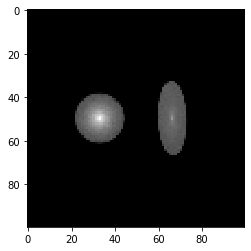

Human Score


0.147059

Prediction


0.144108

In [13]:
# Let's start with our best predictions that the net was able to give

for i in range (5):
    plt.imshow(image.array_to_img(x_original_test[top[i],:,:,:]), cmap='Greys_r') 
    plt.show()

    print("Human Score")
    display(y_test[top[i]])
    print("Prediction")
    display(preds[top[i]][0])

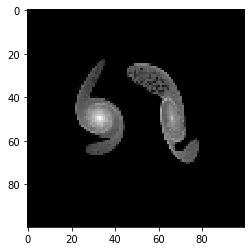

Human Score


0.352941

Prediction


0.1094576

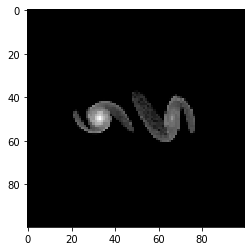

Human Score


0.823529

Prediction


0.53521776

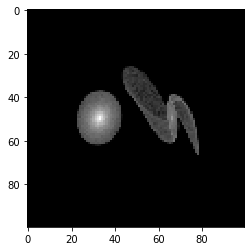

Human Score


0.647059

Prediction


0.37571767

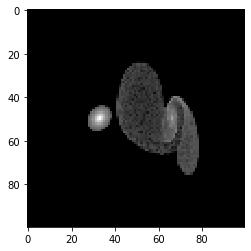

Human Score


0.205882

Prediction


0.6219371

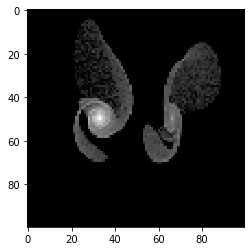

Human Score


0.235294

Prediction


0.60055363

In [14]:
# And for comparison we will also view the worst predictions the model gave

for i in range (5):
    plt.imshow(image.array_to_img(x_original_test[bottom[i],:,:,:]), cmap='Greys_r') 
    plt.show()

    print("Human Score")
    display(y_test[bottom[i]])
    print("Prediction")
    display(preds[bottom[i]][0])

# **3a. Convolution Network**

With our single layer network we are able to show that the network was able to learn and score models.  However, as stated previously, our main goal was to create a convolution network to accomplish this task.  We wanted to improve upon the accuracy of a single layer network, and work towards a possible solution for scoring future galaxy merger images.

##### **Grab images again**

In [15]:
numImages = 600
X=np.concatenate([grab_image_full('miscImgs/',i, numImages) for i in range(numImages)]) 
X /= 255.0

##### **Load in model scores**

In [16]:
# Again let's attach a human score to the images.

Y = np.loadtxt('./miscImgs/scores/humanScores.txt')
Y=Y[0:600]
display(Y[0:10])
display(Y.shape)

array([0.945946, 0.941176, 0.918919, 0.916667, 0.916667, 0.914286,
       0.914286, 0.911765, 0.891892, 0.885714])

(600,)

##### **Shuffle model images and scores**

In [17]:
# Randomize the image data again

p = np.random.permutation(len(X))
Xshuffled = X[p]
Yshuffled = Y[p]

display(Xshuffled.shape)
display(Yshuffled.shape)

(600, 100, 100, 1)

(600,)

##### **Split into training and test data (85% for training and validation)**

In [18]:
x_train = Xshuffled[0:(round(numImages*.85)),:,:]
y_train = Yshuffled[0:(round(numImages*.85))]
x_test = Xshuffled[(round(numImages*.85)): , : , :]
y_test = Yshuffled[(round(numImages*.85)):]

display(x_train.shape)
display(y_train.shape)
display(x_test.shape)
display(y_test.shape)

(510, 100, 100, 1)

(510,)

(90, 100, 100, 1)

(90,)

##### **Load Pre-Trained Convolution Network**

In [19]:
convModel = load_model('ConvModelPaper')

convModel.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 89, 89, 16)        2320      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 82, 82, 32)        32800     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 41, 41, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 41, 41, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 53792)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1721376   
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)               

# **3b. What the Convolution Network accomplishes**

With a convolution network we were able to achieve much better results with our comparisons.  With a larger data set we believe the network would be able to mirror the human scores, or even potentially score a model better than humans could.

In [20]:
preds = convModel.predict(x_test)
diff = preds.flatten() - (y_test)
print("Mean difference")
print("---------------")
display(np.mean(np.abs(diff)))

Mean difference
---------------


0.0831713500582854

##### **Various data plots**

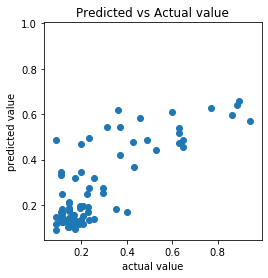

In [21]:
plt.figure()
plt.scatter(y_test, preds)
plt.title("Predicted vs Actual value")
plt.ylabel("predicted value")
plt.xlabel("actual value")
plt.savefig("ConvPredictedVAct.png")
plt.axis('square')
plt.show()

The predicted vs. actual resulst show us that there is less variation from the central y=x line.<br>
It's not quite perfect yet, but there is visible progress over the single layer network.

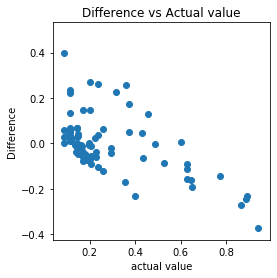

In [22]:
plt.figure()
plt.scatter(y_test, diff)
plt.title("Difference vs Actual value")
plt.ylabel("Difference")
plt.xlabel("actual value")
plt.axis('square')
plt.savefig("ConvDiffVAct.png")
plt.show()

Here is where the results differ most.<br>
The models that were scored highest by humans, received a lower score from our network.<br>
This shows us that the model is using what it has learned to attempt to rate the image in the way a human would, and not compare specific cases it learned through training.

##### **Find the 5 best and worst predictions**

In [23]:
# We can again view our best and worst predictions from the model
# the "top" array being our best, and "bottom" array being our worst
# our ratings are based on how close the model rated a particular image
# in regards to the actual human score attached to the image.

absDiff = np.abs(diff)

bottom = np.argpartition(absDiff, -5)[-5:]
top = np.argpartition(absDiff, 5)[:5]
display(top)
display(bottom)

array([27, 34,  0, 51, 42])

array([56,  9, 38, 76, 81])

##### **Show the 5 models that had the lowest difference between predicted and human score**

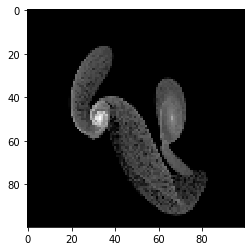

Human Score


0.486486

Prediction


0.4855028

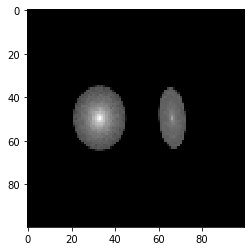

Human Score


0.142857

Prediction


0.14288601

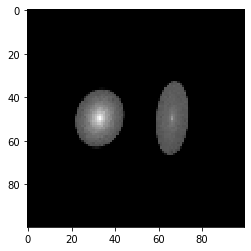

Human Score


0.162162

Prediction


0.15649006

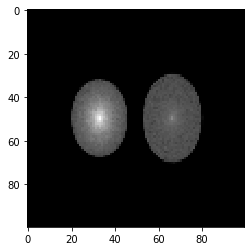

Human Score


0.194444

Prediction


0.1958105

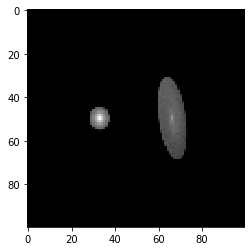

Human Score


0.088235

Prediction


0.090036355

In [24]:
for i in range (5):
    plt.imshow(image.array_to_img(x_test[top[i],:,:,:]), cmap='Greys_r') 
    plt.show()

    print("Human Score")
    display(y_test[top[i]])
    print("Prediction")
    display(preds[top[i]][0])

##### **Show the 5 models that the net had the highest difference between prediction and human score**

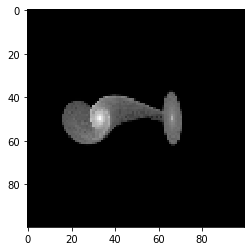

Human Score


0.235294

Prediction


0.49678165

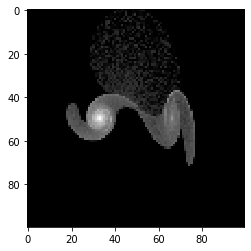

Human Score


0.941176

Prediction


0.5702146

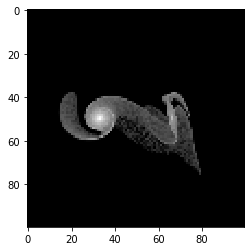

Human Score


0.864865

Prediction


0.59427136

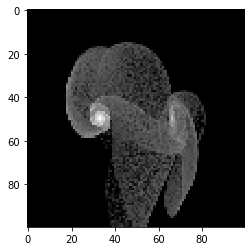

Human Score


0.2

Prediction


0.4688892

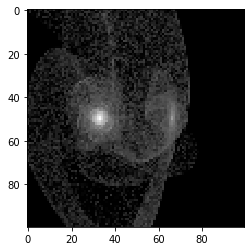

Human Score


0.088235

Prediction


0.48474985

In [25]:
for i in range (5):
    plt.imshow(image.array_to_img(x_test[bottom[i],:,:,:]), cmap='Greys_r') 
    plt.show()

    print("Human Score")
    display(y_test[bottom[i]])
    print("Prediction")
    display(preds[bottom[i]][0])

##### **Show the models that the net gave the highest and lowest scores**

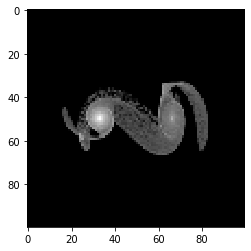

Human Score


0.891892

Prediction


0.65827554

In [26]:
# Let's view our highest scoring model

maxPred = np.amax(preds, axis=0)
maxPredIndex = np.where(preds == maxPred)

plt.imshow(image.array_to_img(x_test[maxPredIndex[0][0],:,:,:]), cmap='Greys_r') 
plt.savefig("ConvPredictedBest.png")
plt.show()

print("Human Score")
display(y_test[maxPredIndex[0][0]])
print("Prediction")
display(preds[maxPredIndex[0][0]][0])

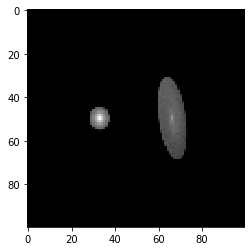

Human Score


0.088235

Prediction


0.090036355

In [27]:
# As well as our lowest scoring model

minPred = np.amin(preds, axis=0)
minPredIndex = np.where(preds == minPred)

plt.imshow(image.array_to_img(x_test[minPredIndex[0][0],:,:,:]), cmap='Greys_r') 
plt.savefig("ConvPredictedBest.png")
plt.show()

print("Human Score")
display(y_test[minPredIndex[0][0]])
print("Prediction")
display(preds[minPredIndex[0][0]][0])

# **4. How to visualize the weights**

It is sometimes helpful to see what the neural network itself views as important.  In order to do this we can model the weights in the way that the net sees them.

In [28]:
def view_weights( singleModel, saveLoc = None ):
    weights = model.get_weights()[0]
    l = weights[:,0]
    #(100,100) dependent on image size
    l = np.reshape( l, (100,100) )

    plt.imshow(l)
    
    if saveLoc != None:
        plt.savefig( saveLoc )
        
    plt.show()

In [29]:
view_weights(singleModel, saveLoc = "singleWeights.png")

NameError: name 'model' is not defined

In [ ]:
inp = convModel.input
outputs = [layer.output for layer in model.layers]
functor = K.function([inp,K.learning_phase()], outputs)

layer_outputs = functor([x_test[10:11,:,:,:],1])

fig,axes = plt.subplots(4,4)
fig.set_figwidth(12)
fig.set_figheight(12)
for x in range(4):
    for y in range(4):
        axes[x,y].imshow(layer_outputs[0][0,:,:,(x*4)+y])
plt.savefig("layer1activations")
plt.show()

In several of the cases, the net focused in correctly on the bridges and tails of the galaxy models.<br>
This is what we want to see and with an increase to the size of the data set and the network itself, we could find the right fit in the future.